# Import Necessary Libraries and  loaad the dataset

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report, precision_score, confusion_matrix
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Load the cleaned dataset
df = pd.read_csv('final.csv')
text_column = 'tweet'  
df[text_column] = df[text_column].astype(str).fillna('')
y = df['class'].values


# Initialize the TF-IDF Vectorizer and  Handle Imbalanced Data with SMOTE

In [2]:
# Split the data into features (X) and labels (y)
X = df[text_column]
y = df['class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=4000)  # Adjust max_features as needed

# Fit and transform the training data, then transform the test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Shape of TF-IDF matrix for training data:", X_train_tfidf.shape)
print("Shape of TF-IDF matrix for test data:", X_test_tfidf.shape)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)



Shape of TF-IDF matrix for training data: (19826, 4000)
Shape of TF-IDF matrix for test data: (4957, 4000)


# Define Models and Pipelines

In [3]:
# Define the models
models = {
    'RandomForest': RandomForestClassifier(),
    'SVM': SVC(),
    'NaiveBayes': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier()
}

# Define parameter grids for each model
param_grids = {
    'RandomForest': {
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    },
    'SVM': {
        'clf__C': [0.1, 1, 10, 100],
        'clf__gamma': [1, 0.1, 0.01, 0.001],
        'clf__kernel': ['linear', 'rbf']
    },
    'NaiveBayes': {
        'clf__alpha': [0.5, 1.0, 1.5]
    },
    'LogisticRegression': {
        'clf__C': [0.01, 0.1, 1, 10, 100]
    },
    'DecisionTree': {
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    }
}

# Define pipelines
pipelines = {
    model_name: ImbPipeline([
        ('tfidf', TfidfVectorizer(max_features=4000)),
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ])
    for model_name, model in models.items()
}

# Hyperparameter Tuning

In [4]:

# Hyperparameter tuning
best_estimators = {}
for model_name, pipeline in pipelines.items():
    random_search = RandomizedSearchCV(pipeline, param_grids[model_name], n_iter=10, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)
    best_estimators[model_name] = random_search.best_estimator_
    print(f"Best parameters for {model_name}: {random_search.best_params_}")



Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for RandomForest: {'clf__n_estimators': 100, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_depth': None}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for SVM: {'clf__kernel': 'rbf', 'clf__gamma': 1, 'clf__C': 1}


C:\Users\chish\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters for NaiveBayes: {'clf__alpha': 1.5}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\Users\chish\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for LogisticRegression: {'clf__C': 1}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for DecisionTree: {'clf__min_samples_split': 10, 'clf__min_samples_leaf': 4, 'clf__max_depth': None}


# Model Evaluation and Visualization

RandomForest - F1 Score: 0.8780435865358828, Precision: 0.8802478998014961
              precision    recall  f1-score   support

      Normal       0.36      0.37      0.37       290
   Offensive       0.94      0.92      0.93      3832
        Hate       0.79      0.87      0.83       835

    accuracy                           0.88      4957
   macro avg       0.70      0.72      0.71      4957
weighted avg       0.88      0.88      0.88      4957



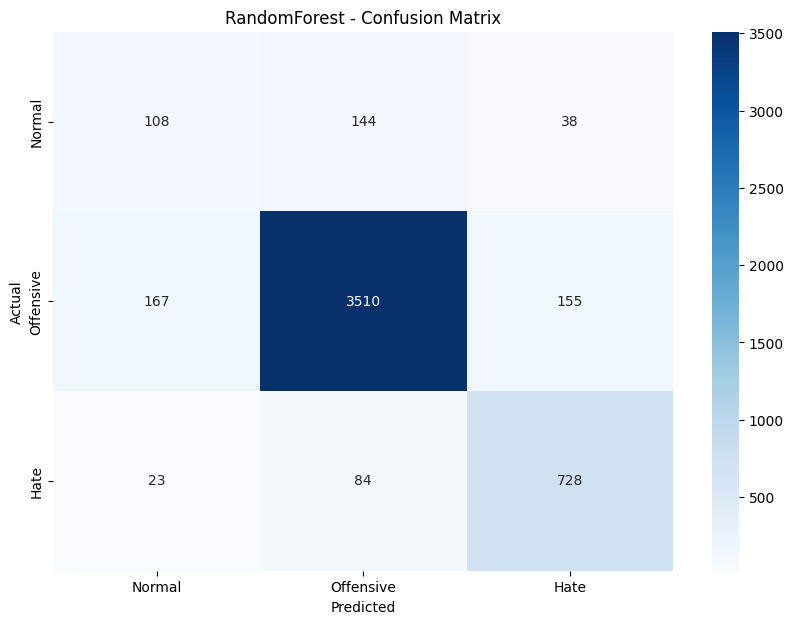

SVM - F1 Score: 0.878138743624795, Precision: 0.8730964312784486
              precision    recall  f1-score   support

      Normal       0.41      0.21      0.27       290
   Offensive       0.92      0.95      0.93      3832
        Hate       0.82      0.84      0.83       835

    accuracy                           0.89      4957
   macro avg       0.72      0.67      0.68      4957
weighted avg       0.87      0.89      0.88      4957



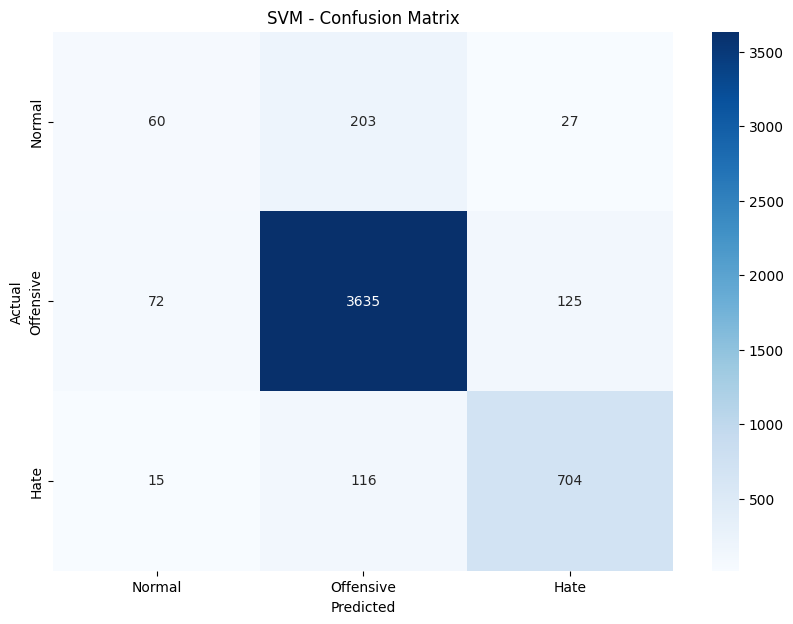

NaiveBayes - F1 Score: 0.8260049352319755, Precision: 0.8665334561821588
              precision    recall  f1-score   support

      Normal       0.23      0.57      0.32       290
   Offensive       0.94      0.82      0.88      3832
        Hate       0.73      0.78      0.75       835

    accuracy                           0.80      4957
   macro avg       0.63      0.72      0.65      4957
weighted avg       0.87      0.80      0.83      4957



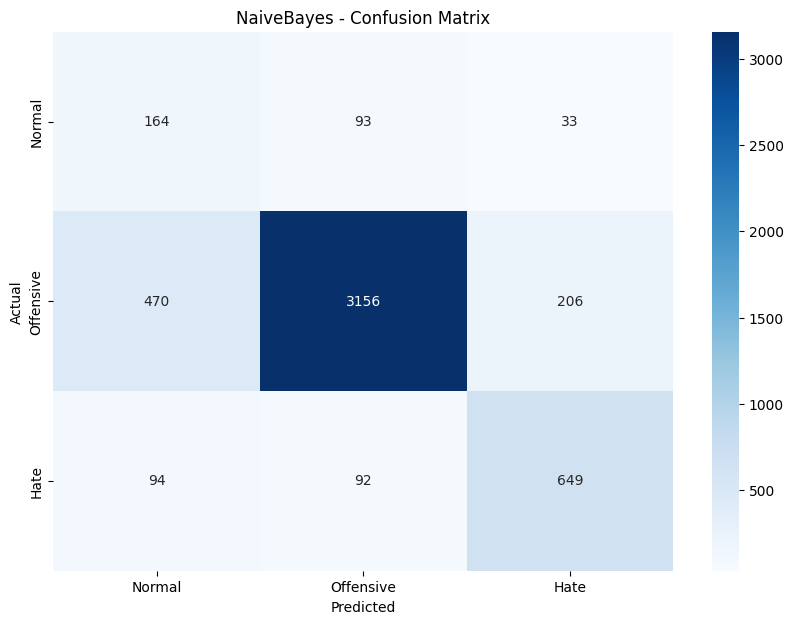

LogisticRegression - F1 Score: 0.854404678534884, Precision: 0.8863995215525444
              precision    recall  f1-score   support

      Normal       0.26      0.55      0.36       290
   Offensive       0.96      0.85      0.90      3832
        Hate       0.76      0.89      0.82       835

    accuracy                           0.84      4957
   macro avg       0.66      0.76      0.69      4957
weighted avg       0.89      0.84      0.85      4957



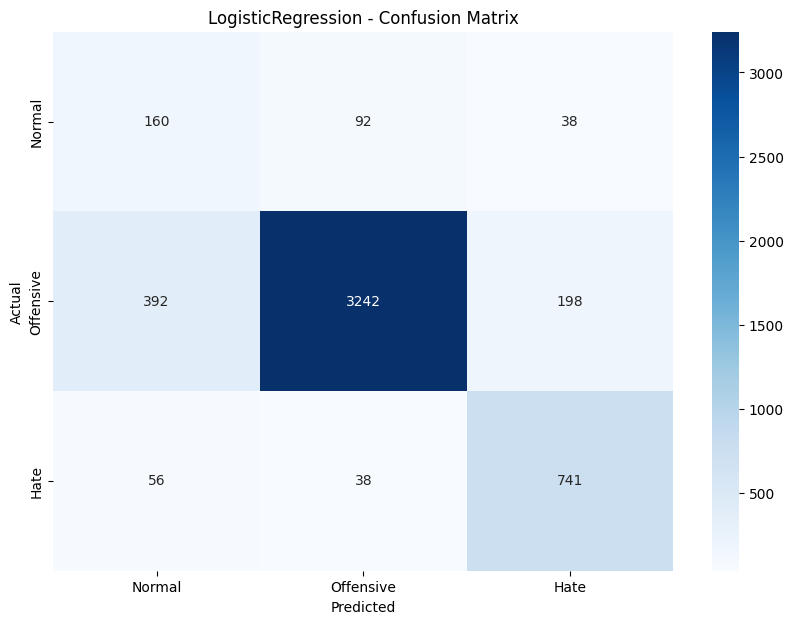

DecisionTree - F1 Score: 0.8584704142481906, Precision: 0.8687025576967174
              precision    recall  f1-score   support

      Normal       0.26      0.38      0.31       290
   Offensive       0.93      0.89      0.91      3832
        Hate       0.80      0.83      0.81       835

    accuracy                           0.85      4957
   macro avg       0.66      0.70      0.68      4957
weighted avg       0.87      0.85      0.86      4957



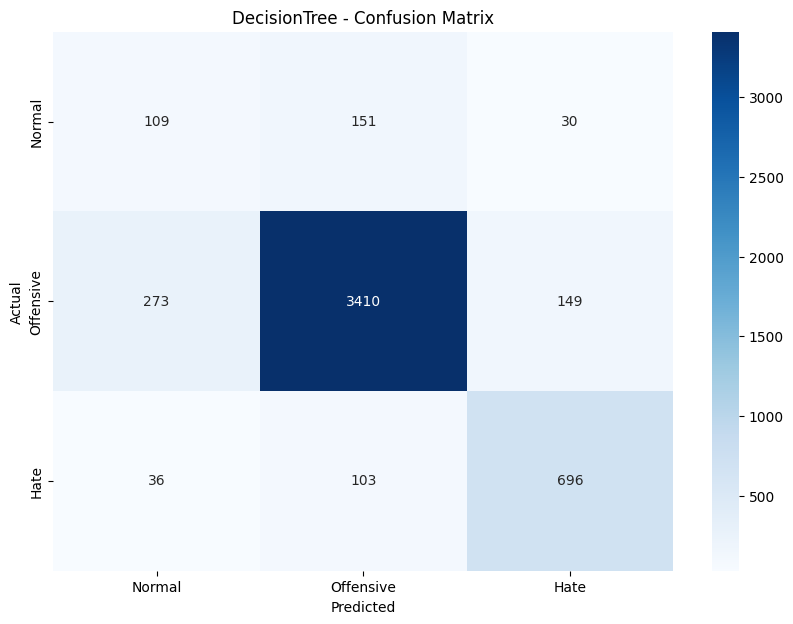

In [5]:
# Function to evaluate and plot results
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'{model_name} - F1 Score: {f1}, Precision: {precision}')
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Offensive', 'Hate']))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Offensive', 'Hate'], yticklabels=['Normal', 'Offensive', 'Hate'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Evaluate all models
for model_name, model in best_estimators.items():
    evaluate_model(model, X_test, y_test, model_name)



# Save the Best Model

In [6]:
# Determine the best model based on F1 score
best_model_name = max(best_estimators, key=lambda name: f1_score(y_test, best_estimators[name].predict(X_test), average='weighted'))
best_model = best_estimators[best_model_name]

# Save the best model
joblib.dump(best_model, 'best_model.pkl')
print(f'The best model is {best_model_name} and it has been saved as best_model.pkl')


The best model is SVM and it has been saved as best_model.pkl
